In [1]:
import sys
### general purpose
import os
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
### palette
import matplotlib.cm as mplcm
import matplotlib.ticker as mticker
#import matplotlib.cm as cm
#div_cmap = mplcm.seismic
import cmocean
from cmocean import cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy.io as sio
from pylab import *
from netCDF4 import Dataset


#sys.path.insert(0,'/home/barboty/Téléchargements/mes notebooks')

#import Fonctions_detection as fd

%matplotlib inline

/home/barboty/anaconda2/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# Recherche de la position - Pour un tourbillon cyclonique


def position(box,Dim):
    
    ### Recherche la position du centre par le maximum de SSH ###
    
    max = -100
    a = 0
    b = 0
    if Dim[0]<0:
        Dim[0] = 0
    if Dim[1]>941:
        Dim[1] = 941
    if Dim[2]<0:
        Dim[2] = 0
    if Dim[3]>747:
        Dim[3] = 747
    

    for i in range(Dim[0], Dim[1]+1):                            #Horizontale
        for j in range(Dim[2], Dim[3]+1):                        #Verticale
            if box[j][i] > max:
                max = box[j][i]
                a = i
                b = j
            
    return (a,b)  # (H,V)

In [3]:
# Recherche de la position - Pour un tourbillon cyclonique


def positionV(box,Dim):
    
    ### Recherche la position du centre par le minimum de vorticite ###
    
    min = 1000
    a = 0
    b = 0
    if Dim[0]<0:
        Dim[0] = 0
    if Dim[1]>941:
        Dim[1] = 941
    if Dim[2]<0:
        Dim[2] = 0
    if Dim[3]>747:
        Dim[3] = 747
    

    for i in range(Dim[0], Dim[1]+1):                            #Horizontale
        for j in range(Dim[2], Dim[3]+1):                        #Verticale
            if box[j,i] < min:
                min = box[j,i]
                a = i
                b = j
            
    return (a,b)  # (H,V)

In [4]:
def Tracking(year, m, box, path, PosIni):
    
    ### Suivi du tourbillon sur le mois m (string),
    ### pour une boite de 'box' pixels qui recherche le nouveau centre (i+1) 
    ### dans la boite centrée sur le centre à l'étape "i"
    ### Path : chemin incomplet vers le fichier à analyser
    ### PosIni : position initiale du tourbillon que l'on veut suivre
    
    DimBoite = [0,0,0,0]
    ListePosition = []
    nbjours = 0

    if (m == '01' or m == '03' or m == '05' or m == '07' or m == '08' or m == '10' or m == '12'):
        nbjours = 31
    elif (m == '02' and year == 2007):
        nbjours = 28
    elif (m == '02' and year == 2008):
        nbjours = 29
    else:
        nbjours = 30
        
    for i in range(1, nbjours+1):
        day = i
        if i<10:
            d = '0' + str(day)
        else:
            d = str(day)
        SSHfile = path + m + 'd' + d + '.1d_SSHMXL.nc'
        
        f = Dataset(SSHfile, "r", format="NETCDF4")
        SSH = f.variables['sossheig'][0]
        if i == 1:
            DimBoite = PosIni
            (hor, ver) = position(SSH, DimBoite)
        else:
            (hor, ver) = position(SSH, DimBoite)
        ListePosition.append([hor,ver])
        DimBoite = [hor-box,hor+box,ver-box,ver+box]
        
    return ListePosition

In [5]:
def TrackingV2(year, m, box, pathSSH, pathVORT, PosIni):
    
    ### Suivi du tourbillon sur le mois m (string),
    ### pour une boite de 'box' pixels qui recherche le nouveau centre (i+1) 
    ### dans la boite centrée sur le centre à l'étape "i"
    ### Path : chemin incomplet vers le fichier à analyser
    ### PosIni : position initiale du tourbillon que l'on veut suivre
    
    DimBoite = [0,0,0,0]
    ListePosition = []
    nbjours = 0

    if (m == '01' or m == '03' or m == '05' or m == '07' or m == '08' or m == '10' or m == '12'):
        nbjours = 31
    elif (m == '02' and year == 2007):
        nbjours = 28
    elif (m == '02' and year == 2008):
        nbjours = 29
    else:
        nbjours = 30
        
    for i in range(1, nbjours+1):
        day = i
        if i<10:
            d = '0' + str(day)
        else:
            d = str(day)
        SSHfile = pathSSH + m + 'd' + d + '.1d_SSHMXL.nc'
        
        f = Dataset(SSHfile, "r", format="NETCDF4")
        S = f.variables['sossheig'][0]
        SSH = np.array(S)
        if i == 1:
            DimBoite = PosIni
            (hor, ver) = position(SSH, DimBoite)
        else:
            (hor, ver) = position(SSH, DimBoite)
            
        VORTfile = pathVORT + m + 'd' + d + '.1d_CURLOVERF.nc'
        
        g = Dataset(VORTfile, "r", format="NETCDF4")
        V = g.variables['socurloverf'][0]
        VORT = np.array(V)
        Nbox = 20
        (nhor,nver) = positionV(VORT, [hor-Nbox,hor+Nbox,ver-Nbox,ver+Nbox])
        (Nhor,Nver) = positionV(VORT, [nhor-Nbox,nhor+Nbox,nver-Nbox,nver+Nbox])
        
        ListePosition.append([Nhor,Nver])
        DimBoite = [Nhor-box,Nhor+box,Nver-box,Nver+box]
        
    return ListePosition

In [44]:
def TrackingSSHMEAN(year, m, box, pathSSH, pathVORT, PosIni):
    
    ### Suivi du tourbillon sur le mois m (string),
    ### pour une boite de 'box' pixels qui recherche le nouveau centre (i+1) 
    ### dans la boite centrée sur le centre à l'étape "i"
    ### Path : chemin incomplet vers le fichier à analyser
    ### PosIni : position initiale du tourbillon que l'on veut suivre
    
    DimBoite = [0,0,0,0]
    ListePosition = []
    nbjours = 0

    if (m == '01' or m == '03' or m == '05' or m == '07' or m == '08' or m == '10' or m == '12'):
        nbjours = 31
    elif (m == '02' and year == 2007):
        nbjours = 28
    elif (m == '02' and year == 2008):
        nbjours = 29
    else:
        nbjours = 30
        
    for i in range(1, nbjours+1):
        day = i
        if i<10:
            d = '0' + str(day)
        else:
            d = str(day)
        SSHfile = pathSSH + m + 'd' + d + '.1d_SSHMEAN.nc'
        
        f = Dataset(SSHfile, "r", format="NETCDF4")
        SSH = f.variables['sossheig'][0]
        SSH2 = np.array(SSH)
        if i == 1:
            DimBoite = PosIni
            (hor, ver) = position(SSH2, DimBoite)
        else:
            (hor, ver) = position(SSH2, DimBoite)
        VORTfile = pathVORT + m + 'd' + d + '.1d_CURLOVERF.nc'
        
        g = Dataset(VORTfile, "r", format="NETCDF4")
        V = g.variables['socurloverf'][0]
        VORT = np.array(V)                                # Environ 375m de profondeur
        Nbox = 10
        (nhor,nver) = positionV(VORT, [hor-Nbox,hor+Nbox,ver-Nbox,ver+Nbox])
        (Nhor,Nver) = positionV(VORT, [nhor-Nbox,nhor+Nbox,nver-Nbox,nver+Nbox])

        
        ListePosition.append([Nhor,Nver])
        DimBoite = [Nhor-box,Nhor+box,Nver-box,Nver+box]
        
    return ListePosition

In [38]:
def TrackingFevrier(jour, m, box, pathSSH, pathVORT, PosIni):
    
    ### Suivi du tourbillon sur le mois m (string),
    ### pour une boite de 'box' pixels qui recherche le nouveau centre (i+1) 
    ### dans la boite centrée sur le centre à l'étape "i"
    ### Path : chemin incomplet vers le fichier à analyser
    ### PosIni : position initiale du tourbillon que l'on veut suivre
    
    DimBoite = [0,0,0,0]
    ListePosition = []
    
    if (m=='02'):
        nbjours = 28
    if (m=='03'):
        nbjours = 31
        
    for i in range(jour, nbjours+1):
        
        if DimBoite[0]<0:
            DimBoite[0]=0
        if DimBoite[1]>941:
            DimBoite[1]=941
        if DimBoite[2]<0:
            DimBoite[2]=0
        if DimBoite[3]>747:
            DimBoite[3]=747
        
        day = i
        if i<10:
            d = '0' + str(day)
        else:
            d = str(day)
        SSHfile = pathSSH + m + 'd' + d + '.1d_SSHMEAN.nc'
        
        f = Dataset(SSHfile, "r", format="NETCDF4")
        S = f.variables['sossheig'][0]
        SSH = np.array(S)
        if i == jour:
            DimBoite = PosIni
            (hor, ver) = position(SSH, DimBoite)
        else:
            (hor, ver) = position(SSH, DimBoite)
            
        VORTfile = pathVORT + m + 'd' + d + '.1d_CURLOVERF.nc'
        
        g = Dataset(VORTfile, "r", format="NETCDF4")
        V = g.variables['socurloverf'][0]
        VORT = np.array(V)                                 # Environ 375m de profondeur
        Nbox = 15
        (nhor,nver) = positionV(VORT, [hor-Nbox,hor+Nbox,ver-Nbox,ver+Nbox])
        (Nhor,Nver) = positionV(VORT, [nhor-Nbox,nhor+Nbox,nver-Nbox,nver+Nbox])

        
        ListePosition.append([Nhor,Nver])
        DimBoite = [Nhor-box,Nhor+box,Nver-box,Nver+box]
        
        
    return ListePosition

In [8]:
# Conversion des coordonnées en longitude/latitude
def ConversionDegree(Position):
    A=[]
    for i in range (len(Position)):
        lat = Position[i][1]                                             #Tableau sur grille avec origine 1/1
        lon = Position[i][0]
        A.append([nav_lon[lat-1][lon-1],nav_lat[lat-1][lon-1]])          #Tableau avec origine 0/0
    return A

In [9]:
# Fonction utile pour visualiser les coupes aux alentours des tourbillons

def choix_fichier(path, PosCentre, donnee):
    
        ### Renvoie le x_centre et y_centre DE LA GRILLE ###
        
    x_centre = PosCentre[jour-1][0]
    y_centre = PosCentre[jour-1][1]
    
    j = str(jour)
    #m = str(mois)
    
    if donnee == 'U':
        file = path+'.1d_gridU.nc' 
    elif donnee == 'V':
        file = path+'.1d_gridV.nc'   
    elif donnee == 'T' or donnee == 'S':
        file = path+'.1d_gridT.nc'   
    elif donnee == 'D':    
        file = 'rien'
    return (file,x_centre,y_centre)


In [10]:
#Chemins pour 2007

pathR = '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2007/NATL60LAB-MJM155_y2007m'
pathRM = '/home/barboty/Work/SSHmean/NATL60LAB-MJM155_y2007m'
pathV = '/home/barboty/Work/VORT62/NATL60LAB-MJM155_y2007m'

In [11]:
file = '/home/barboty/Work/SSHmean/NATL60LAB-MJM155_y2007m02d18.1d_SSHMEAN.nc'

f = Dataset(file, "r", format="NETCDF4")
b = f.variables['sossheig'][0]
box = np.array(b)
Dim = [531, 591, 618, 678]

max = -1000
a = 0
b = 0

    

for i in range(Dim[0], Dim[1]+1):                            #Horizontale
    for j in range(Dim[2], Dim[3]+1):                        #Verticale
        if box[j][i] > max:
            max = box[j][i]
            a = i
            b = j
            
box.shape
            

(748, 942)

In [12]:
box[540,650]

0.26613092

In [13]:
# Tourbillon etudie au début. A le même parcours que le tourbillon 3

Janvier = Tracking(2007,'01',50, pathR, [171, 271, 518, 618])
Fevrier = Tracking(2007,'02',40, pathR, [238, 338, 505, 605])
Mars = Tracking(2007,'03',30, pathR, [291, 331, 518, 558])
Avril = Tracking(2007,'04',50, pathR, [378,458,539,619])
Mai = Tracking(2007,'05',50, pathR, [431,531,517,617])

### En mai, lors de la fusion, le centre du tourbillon devient une étape trop vite le centre du nouveau tourbillon ###

Juin = Tracking(2007,'06',50, pathR, [419,519,419,519])
Juillet = Tracking(2007,'07',50, pathR, [314,414,380,480])
Aout = Tracking(2007,'08',50, pathR, [238,338,267,367])
Septembre = Tracking(2007,'09',50, pathR, [260,360,305,405])
Octobre = Tracking(2007,'10',50, pathR, [258,358,254,354])
Novembre = Tracking(2007,'11',40, pathR, [259,359,261,361])

### 29 et 30 Novembre, mauvais centre, fusion partielle des tourbillons ###

Decembre = Tracking(2007,'12',50, pathR, [319,419,312,412])






In [48]:
# Tourbillon 1 - Formation le 14 Fevrier 2007 / celui de gauche sur le premier merging

# 8 Fevrier [592,602],
# 9 Fevrier [584,617],
# 10 Fevrier [572,632]
# 11 Fevrier [563,646]
# 12 Fevrier [554,656]
# 13 Fevrier [538,672]
# 14 Fevrier [524,685]

FevrierT2 = TrackingFevrier(14,'02',35, pathRM, pathV , [494, 554, 655, 715])
FevrierT2 = [[592,602],[584,617],[572,632],[563,646],[554,656],[538,672]] + FevrierT2

MarsT2bis = TrackingSSHMEAN(2007,'03',40, pathRM, pathV, [300, 380, 584, 664])
AvrilT2bis = TrackingSSHMEAN(2007,'04',40, pathRM, pathV, [202, 282, 536, 616])
MaiT2bis = TrackingSSHMEAN(2007,'05',30, pathRM, pathV, [321, 401, 389, 469])
JuinT2bis = TrackingSSHMEAN(2007,'06',50, pathRM, pathV, [419,519,419,519])

#Puis pareil que T1...

In [15]:
print(FevrierT2)

[[592, 602], [584, 617], [572, 632], [563, 646], [554, 656], [538, 672], [510, 684], [507, 694], [505, 687], [481, 686], [464, 689], [450, 688], [432, 684], [408, 674], [389, 672], [376, 666], [367, 661], [363, 652], [356, 639], [348, 630], [342, 623]]


In [36]:
# Tourbillon 2 - Formation le 10 Mars 2007

FevrierTM = TrackingFevrier(18,'02',30, pathRM, pathV , [531, 591, 618, 678])

MarsTM = TrackingSSHMEAN(2007,'03',40, pathRM, pathV, [461, 561, 666, 747])

#Apparition et merging partiel avec tourbillon 1/ merging "complet" avec tourbillon 3.


In [17]:
# Tourbillon 3 - Present des le 1er Janvier 2007 / celui du bas sur le premier merging

JanvierT3 = TrackingSSHMEAN(2007,'01', 50, pathRM, pathV, [171,271,522,622])
FevrierT3 = TrackingSSHMEAN(2007,'02', 40, pathRM, pathV, [238,338,505,605])
MarsT3 = TrackingSSHMEAN(2007,'03', 30, pathRM, pathV, [261,361,488,588])
AvrilT3 = TrackingSSHMEAN(2007,'04', 50, pathRM, pathV, [368,468,529,629])
MaiT3 = TrackingSSHMEAN(2007,'05', 50, pathRM, pathV, [396,496,533,633])


#Fin mai, les 3 tourbillons ont mergé

In [52]:
# Test nouveau code

JanvierT3 = TrackingSSHMEAN(2007,'01', 50, pathRM, pathV, [171,271,522,622])
FevrierT3 = TrackingSSHMEAN(2007,'02', 40, pathRM, pathV, [238,338,505,605])
MarsT3 = TrackingSSHMEAN(2007,'03', 25, pathRM, pathV, [261,361,488,588])
AvrilT3 = TrackingSSHMEAN(2007,'04', 50, pathRM, pathV, [368,468,529,629])
MaiT3 = TrackingSSHMEAN(2007,'05', 35, pathRM, pathV, [396,496,533,633])



In [37]:
print(FevrierTM)

[[562, 642], [561, 661], [557, 679], [554, 684], [535, 699], [532, 707], [530, 709], [532, 715], [528, 710], [532, 704], [511, 716]]


In [53]:
print(MaiT3)

[[448, 579], [451, 577], [460, 571], [473, 555], [483, 533], [484, 505], [480, 490], [479, 485], [479, 482], [480, 479], [482, 475], [480, 467], [479, 459], [478, 455], [479, 451], [481, 443], [483, 439], [489, 436], [491, 430], [494, 423], [494, 415], [494, 409], [492, 403], [492, 397], [487, 391], [482, 387], [475, 387], [471, 389], [463, 401], [456, 416], [465, 464]]


In [39]:
print(FevrierTM)

[[562, 642], [561, 661], [557, 679], [554, 684], [535, 699], [532, 707], [530, 709], [532, 715], [528, 710], [532, 704], [511, 716]]


In [14]:
# Tracking sur l'année 2008

Janvier2 = Tracking(2008,'01',50, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [328,428,181,281])
Fevrier2 = Tracking(2008,'02',40, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [411,511,134,234])
Mars2 = Tracking(2008,'03',30, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [470,570,148,248])
Avril2 = Tracking(2008,'04',50, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [516,616,147,247])
Mai2 = Tracking(2008,'05',50, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [428,528,39,139])
Juin2 = Tracking(2008,'06',30, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [442,542,72,172])

### Petite avance sur le merging ###

Juillet2 = Tracking(2008,'07',50, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [472,572,59,159])
Aout2 = Tracking(2008,'08',50, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [532,632,20,120])
Septembre2 = Tracking(2008,'09',50, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [487,587,12,112])
Octobre2 = Tracking(2008,'10',50, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [556,656,2,102])
Novembre2 = Tracking(2008,'11',40, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [524,624,0,88])
Decembre2 = Tracking(2008,'12',50, '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/2008/NATL60LAB-MJM155_y2008m', [572,672,0,98])



In [9]:
# Liste des coordonnées converties
# 2007

A = ConversionDegree(Janvier)
B = ConversionDegree(Fevrier)
C = ConversionDegree(Mars)
D = ConversionDegree(Avril)
E = ConversionDegree(Mai)
F = ConversionDegree(Juin)
G = ConversionDegree(Juillet)
H = ConversionDegree(Aout)
I = ConversionDegree(Septembre)
J = ConversionDegree(Octobre)
K = ConversionDegree(Novembre)
L = ConversionDegree(Decembre)

In [10]:
# 2008

M = ConversionDegree(Janvier2)
N = ConversionDegree(Fevrier2)
O = ConversionDegree(Mars2)
P = ConversionDegree(Avril2)
Q = ConversionDegree(Mai2)
R = ConversionDegree(Juin2)
S = ConversionDegree(Juillet2)
T = ConversionDegree(Aout2)
U = ConversionDegree(Septembre2)
V = ConversionDegree(Octobre2)
W = ConversionDegree(Novembre2)
X = ConversionDegree(Decembre2)

(54, 64)

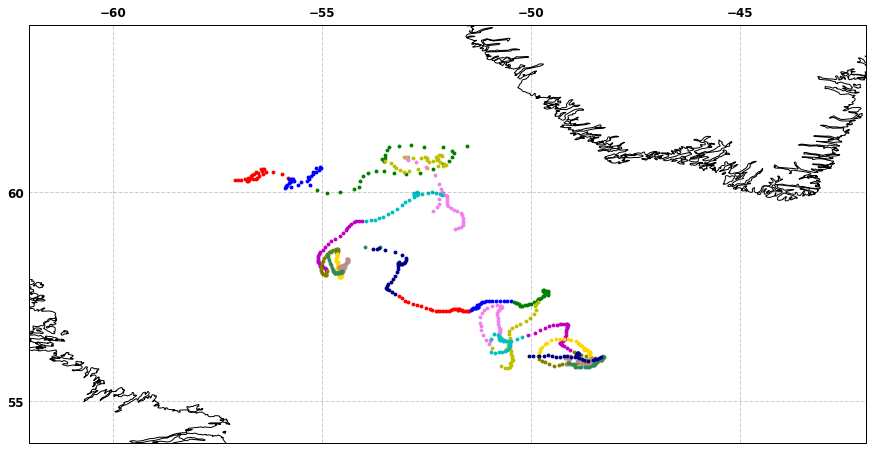

In [22]:
# Trace du mouvement du tourbillon sur deux ans (2007/2008)

fig = plt.figure(figsize=(15,10))
pj = ccrs.PlateCarree()
ax = plt.axes(projection=pj)
ax.coastlines(resolution="10m")

gl = ax.gridlines(crs=pj, draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')

label_style = {'size': 12, 'color': 'black', 'weight': 'bold'}

gl.xlabel_style = label_style
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator(np.arange(-90,20,5,dtype=float))

gl.ylabel_style = label_style
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator(np.arange(15,80,5,dtype=float))

# Trace

for i in range (len(A)):  
    plt.scatter(A[i][0],A[i][1],linewidth='0', s=15, color='r')
for i in range (len(B)):
    plt.scatter(B[i][0],B[i][1],linewidth='0', s=15, color='b')
for i in range (len(C)):    
    plt.scatter(C[i][0],C[i][1],linewidth='0', s=15, color='g')
for i in range (len(D)):
    plt.scatter(D[i][0],D[i][1],linewidth='0', s=15, color='y')
for i in range (len(E)):   
    plt.scatter(E[i][0],E[i][1],linewidth='0', s=15, color='violet')
for i in range (len(F)):
    plt.scatter(F[i][0],F[i][1],linewidth='0', s=15, color='c')
for i in range (len(G)):
    plt.scatter(G[i][0],G[i][1],linewidth='0', s=15, color='m')
for i in range (len(H)):
    plt.scatter(H[i][0],H[i][1],linewidth='0', s=15, color='olive')
for i in range (len(I)):
    plt.scatter(I[i][0],I[i][1],linewidth='0', s=15, color='gold')
for i in range (len(J)):
    plt.scatter(J[i][0],J[i][1],linewidth='0', s=15, color='rosybrown')
for i in range (len(K)):
    plt.scatter(K[i][0],K[i][1],linewidth='0', s=15, color='seagreen')
for i in range (len(L)):
    plt.scatter(L[i][0],L[i][1],linewidth='0', s=15, color='darkblue')
for i in range (len(M)):  
    plt.scatter(M[i][0],M[i][1],linewidth='0', s=15, color='r')
for i in range (len(N)):
    plt.scatter(N[i][0],N[i][1],linewidth='0', s=15, color='b')
for i in range (len(O)):    
    plt.scatter(O[i][0],O[i][1],linewidth='0', s=15, color='g')
for i in range (len(P)):
    plt.scatter(P[i][0],P[i][1],linewidth='0', s=15, color='y')
for i in range (len(Q)):   
    plt.scatter(Q[i][0],Q[i][1],linewidth='0', s=15, color='violet')
for i in range (len(R)):
    plt.scatter(R[i][0],R[i][1],linewidth='0', s=15, color='c')
for i in range (len(S)):
    plt.scatter(S[i][0],S[i][1],linewidth='0', s=15, color='m')
for i in range (len(T)):
    plt.scatter(T[i][0],T[i][1],linewidth='0', s=15, color='olive')
for i in range (len(U)):
    plt.scatter(U[i][0],U[i][1],linewidth='0', s=15, color='gold')
for i in range (len(V)):
    plt.scatter(V[i][0],V[i][1],linewidth='0', s=15, color='rosybrown')
for i in range (len(W)):
    plt.scatter(W[i][0],W[i][1],linewidth='0', s=15, color='seagreen')
for i in range (len(X)):
    plt.scatter(X[i][0],X[i][1],linewidth='0', s=15, color='darkblue')    
    
    # limits
plt.xlim((-62,-42))
plt.ylim((54,64)) 


In [16]:
# Liste des niveaux de profondeur - cellule/cellule
Prof = '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-I/NATL60LAB_v4.1_cdf_mesh_zgr.nc'

f = Dataset(Prof, "r", format = "NETCDF4")
qq=f.variables['e3w'][0,:,150,150]

In [17]:
# Création des niveaux de profondeur - Avec les niveaux cellule/cellule

Depth = [0]*300
i=0
for i in range(300):
    if (i == 0):
        Depth[0] = 0.480455 #Le premier niveau sur ncview
    else:
        Depth[i] = Depth[i-1]+qq[i]

        
# Possiblement améliorable ?

In [18]:
Depth[62]

375.64627071102143

In [28]:
# Chemins complets

## Chemins persos a mettre a jour si utilisation par une autre personne ##

jour = 2.0
j = str(jour)
j = j[0]+j[2]
jour = int(j)
centre = MarsTM[jour-11]
#centre = Mars[jour-1]
#centre = MarsT2bis[jour-1]
#centre = MarsT3[jour-1]

centreX = centre[0]-1
centreY = centre[1]-1
mois = '03'
annee = '2007'
date = j +'_'+ mois + '_' + annee

Mois= ''
if mois == '01' : Mois= 'Janvier' 
elif mois== '02': Mois = 'Fevrier'
elif mois== '03': Mois= 'Mars'
elif mois== '04': Mois = 'Avril'
elif mois== '05': Mois = 'Mai'
elif mois== '06': Mois = 'Juin'
elif mois== '07': Mois= 'Juillet'
elif mois== '08': Mois = 'Aout'
elif mois== '09': Mois = 'Septembre'
elif mois== '10': Mois= 'Octobre'
elif mois== '11': Mois = 'Novembre'
elif mois== '12': Mois = 'Decembre'
# Documentation_Tourbillon


local = '/home/barboty/Work/Documentation_Tourbillon' + annee +'/'+ Mois + annee
cal1 = '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-MJM155-S/1d/'
datas = '/mnt/barboty/equipes/meom/MODEL_SET/NATL60/NATL60LAB-I/'
chemin = '/NATL60LAB-MJM155_y'+annee+'m' + mois + 'd' + j + '.1d'
CURL = '_CURLOVERF.nc'
SSH = '_SSHMXL.nc'
Temp = '_gridT.nc'
VITA = '_VITA.nc'
mask = 'NATL60LAB_v4.1_cdf_byte_mask.nc'


## Chemins utiles pour la suite

CompletePath = local + chemin + CURL
CompletePathV = local + chemin + VITA
LatLon = local + chemin + CURL
Melange = cal1 + annee + chemin + SSH
Temperature = cal1+annee+chemin+Temp
ToMask = datas + mask


In [58]:
jour = 1
MarsT2bis[jour-1]


[336, 614]

In [59]:
MarsTM[jour-1]

[512, 706]

In [60]:
MarsT3[jour-1]

[323, 542]

In [54]:
f = xr.open_dataset('/home/barboty/Work/Documentation_Tourbillon2007/Mars2007/NATL60LAB-MJM155_y2007m03d04.1d_CURLOVERF.nc')
nav_lat = f.nav_lat
nav_lon = f.nav_lon
curl= f.socurloverf[0,0]


In [27]:
# Chargement des donnees

s = xr.open_dataset(Temperature)
Sx = s.vosaline[0,:,centreY,:]
Sy = s.vosaline[0,:,:,centreX]

f = Dataset(LatLon, "r", format="NETCDF4")
nav_lat = f.variables['nav_lat']
nav_lon = f.variables['nav_lon']

a = Dataset(Melange, "r", format="NETCDF4")
lonT=a.variables['nav_lon'][centreY,:] # Longitude
latT=a.variables['nav_lat'][:,centreX] # Latitude

Mas = Dataset(ToMask, "r", format = "NETCDF4")
ValeurMask = Mas.variables['tmask'][0]

g = Dataset(Temperature, "r", format="NETCDF4")
Tx = g.variables['votemper'][0,:,centreY,:]
Ty = g.variables['votemper'][0,:,:,centreX]

h = Dataset(Melange, "r", format = "NETCDF4")
MXL = h.variables['somxl010'][0]

k = Dataset(CompletePath, "r", format = "NETCDF4")
VV = k.variables['socurloverf'][0,:,centreY,:]
UU = k.variables['socurloverf'][0,:,:,centreX]
vv = k.variables['socurloverf'][0,0,:,:]

l = Dataset(CompletePathV, "r", format = "NETCDF4")
VITUX = l.variables['sovitua'][0,:,centreY,:]
VITUY = l.variables['sovitua'][0,:,:, centreX]
Dpt = l.variables['deptht']
DPT = np.array(Dpt)

VITVX = l.variables['sovitva'][0,:,centreY,:]
VITVY = l.variables['sovitva'][0,:,:,centreX]

In [56]:
# Creation des tableaux de longitude/latitude

lon=f.variables['nav_lon'][centreY,:] # Longitude
lat=f.variables['nav_lat'][:,centreX] # Latitude

INTX = f.variables['nav_lon'][centreY,centreX-50:centreX+50]
if centreX-50 <0:
    INTX = f.variables['nav_lon'][centreY,0:centreX+50]
elif centreX+50 > 942:
    INTX = f.variables['nav_lon'][centreY,centreX-50:942]
else:
    INTX = f.variables['nav_lon'][centreY,centreX-50:centreX+50]
if centreY-50<0:
    INTY = f.variables['nav_lat'][0:centreY+50,centreX]
elif centreY+50 > 748:
    INTY = f.variables['nav_lat'][centreY-50:748,centreX]
else:
    INTY = f.variables['nav_lat'][centreY-50:centreY+50,centreX]



/home/barboty/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until
/home/barboty/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  after removing the cwd from sys.path.
/home/barboty/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  
/home/barboty/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  if sys.path[0] == '':
/home/barboty/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: WARNING: missing_value not used since it
cannot be safely c

In [57]:
print(lonT[centreX],lon[centreX])

(-54.666576, -54.659695)


In [58]:
print(latT[centreY],lat[centreY])

(61.325794, 61.331158)


In [59]:
def TraceVitesse(X,D,V,PosCentre,intervalle, DATE, indice):
    
    ### Permet de tracer la vitesse sur un intervalle X, sur tous les niveaux de profondeurs, pour la vitesse étudiée ###
    
    VIT = np.array(V)
    
    plt.gca().invert_yaxis()
    ax = plt.subplot(111)
    ax.set_ylim(3900,0)
    ax.set_ylabel('Profondeur (m)',fontsize=12)
    Limite = PosCentre - intervalle
    
    
    if (intervalle == 0 and (indice == 'VITUX' or indice == 'VITVX')):
        if indice[3]== 'U':
            plt.title('Coupe zonale de la vitesse selon i')
        else :
            plt.title('Coupe zonale de la vitesse selon j')
        ax.set_xlabel('Longitude',fontsize=12)
        pcolor(X,D,VIT, cmap = 'seismic', vmin = -0.4, vmax =0.4)
        
        
    elif (intervalle == 0 and (indice =='VITUY' or indice == 'VITVY')):
        if (indice[3] == 'U'):
            plt.title('Coupe meridionale de la vitesse selon i')
        else:
            plt.title('Coupe meridionale de la vitesse selon j')
        ax.set_xlabel('Latitude',fontsize=12)
        pcolor(X,D,VIT, cmap = 'seismic', vmin = -0.4, vmax =0.4)

        
    elif (indice == 'VITUX'):
        plt.title('Coupe zonale de la vitesse selon i', fontsize = 20)
        ax.set_xlabel('Longitude',fontsize=12)

        v = 'i'
        vmin = -0.2
        vmax = 0.2
    elif (indice == 'VITUY'):
        plt.title('Coupe meridionale de la vitesse selon i', fontsize = 20)
        ax.set_xlabel('Latitude',fontsize=12)

        v = 'i'
        vmin = -0.9
        vmax = 0.9
    elif (indice == 'VITVX'):
        plt.title('Coupe zonale de la vitesse selon j', fontsize = 20)
        ax.set_xlabel('Longitude',fontsize=12)

        v = 'j'
        vmin = -0.5
        vmax = 0.5
    elif (indice == 'VITVY'):
        plt.title('Coupe meridionale de la vitesse selon j', fontsize = 20)
        ax.set_xlabel('Latitude',fontsize=12)

        v = 'j'
        vmin = -0.2
        vmax = 0.2
    if (Limite <0 and intervalle !=0):
        pcolor(X, D, VIT[:,0:PosCentre+intervalle],cmap='seismic', vmin = vmin, vmax = vmax)
    if ( Limite >=0 and intervalle != 0):
        pcolor(X, D, VIT[:,PosCentre-intervalle:PosCentre+intervalle],cmap='seismic', vmin = vmin, vmax = vmax) 

    plt.colorbar()

    plt.savefig(DATE + indice + str(intervalle),bbox_inches='tight')


In [60]:
def TraceSalinite(X,D,S,V,PosCentre,intervalle, DATE, indice):
    
    ### Permet de tracer la vitesse sur un intervalle X, sur tous les niveaux de profondeurs, pour la vitesse étudiée ###
    
    
    Profondeur = 3800
    SAL = np.array(S)
    VIT = np.array(V)
    plt.figure(figsize=(20,15))
    plt.gca().invert_yaxis()
    ax = plt.subplot(111)
    ax.set_ylim(Profondeur,0)
    ax.set_ylabel('Profondeur (m)',fontsize=12)
    
    if (intervalle == 0):
        if indice[8]=='X':
            plt.title('Coupe zonale de la salinite sur une section complete')
            ax.set_xlabel('Longitude',fontsize=12)

        else:
            plt.title('Coupe meridionale de la salinite sur une section complete')
            ax.set_xlabel('Latitude',fontsize=12)

        pcolor(X,D,SAL, cmap='tab20b', vmin = 34.8)
        contour = ax.contour(X,D,VIT,[-0.4], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        contour = ax.contour(X,D,VIT,[-0.15], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        #contour = ax.contour(X,D,VIT,[0], colors = 'blue', alpha = 0.5, linewidth = 1, antialiased = True)
        #plt.clabel(contour,fmt =  '%r',colors = 'g', fontsize = 12)
        contour = ax.contour(X,D,VIT,[0.15], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        contour = ax.contour(X,D,VIT,[0.4], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        
        xx = np.array([X[PosCentre], X[PosCentre]])
        yy = np.array([Profondeur, 0])
        plt.plot(xx, yy)



    else :
        if indice[8]=='X':
            plt.title('Coupe zonale de la salinite au voisinage du tourbillon')
            ax.set_xlabel('Longitude',fontsize=12)

        else:
            plt.title('Coupe meridionale de la salinite au voisinage du tourbillon')
            ax.set_xlabel('Latitude',fontsize=12)
        
    if (PosCentre-intervalle<0 and intervalle != 0):
        pcolor(X, D, SAL[:,0:PosCentre+intervalle],cmap='tab20b')
        
        contour = ax.contour(X,D,VIT[:,0:PosCentre+intervalle],[-0.2], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)

        contour = ax.contour(X,D,VIT[:,0:PosCentre+intervalle],[-0.1], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        contour = ax.contour(X,D,VIT[:,0:PosCentre+intervalle],[0], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        contour = ax.contour(X,D,VIT[:,0:PosCentre+intervalle],[0.1], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        contour = ax.contour(X,D,VIT[:,0:PosCentre+intervalle],[0.2], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        
        xx = np.array([X[len(X)-50], X[len(X)-50]])
        yy = np.array([Profondeur, 0])
        plt.plot(xx, yy)


        
    elif (PosCentre-intervalle>=0 and intervalle != 0):
        pcolor(X, D, SAL[:,PosCentre-intervalle:PosCentre+intervalle],cmap='tab20b')
        
        contour = ax.contour(X,D,VIT[:,PosCentre-intervalle:PosCentre+intervalle],[-0.2], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        contour = ax.contour(X,D,VIT[:,PosCentre-intervalle:PosCentre+intervalle],[-0.1], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        contour = ax.contour(X,D,VIT[:,PosCentre-intervalle:PosCentre+intervalle],[0], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        contour = ax.contour(X,D,VIT[:,PosCentre-intervalle:PosCentre+intervalle],[0.1], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
        contour = ax.contour(X,D,VIT[:,PosCentre-intervalle:PosCentre+intervalle],[0.2], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'k', fontsize = 12)
    
        xx = np.array([X[50], X[50]])
        yy = np.array([Profondeur, 0])
        plt.plot(xx, yy)


    plt.colorbar()

    plt.savefig(DATE + indice + str(intervalle),bbox_inches='tight')


In [61]:
len(INTX)

100

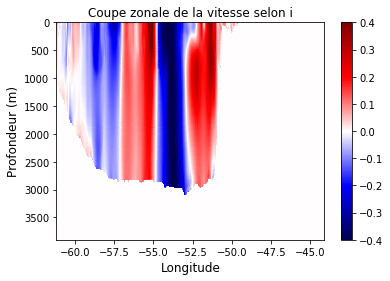

In [64]:
Qvit = 'VITUX'

TraceVitesse(lon, DPT, VITUX, centreX, 0, date, Qvit)

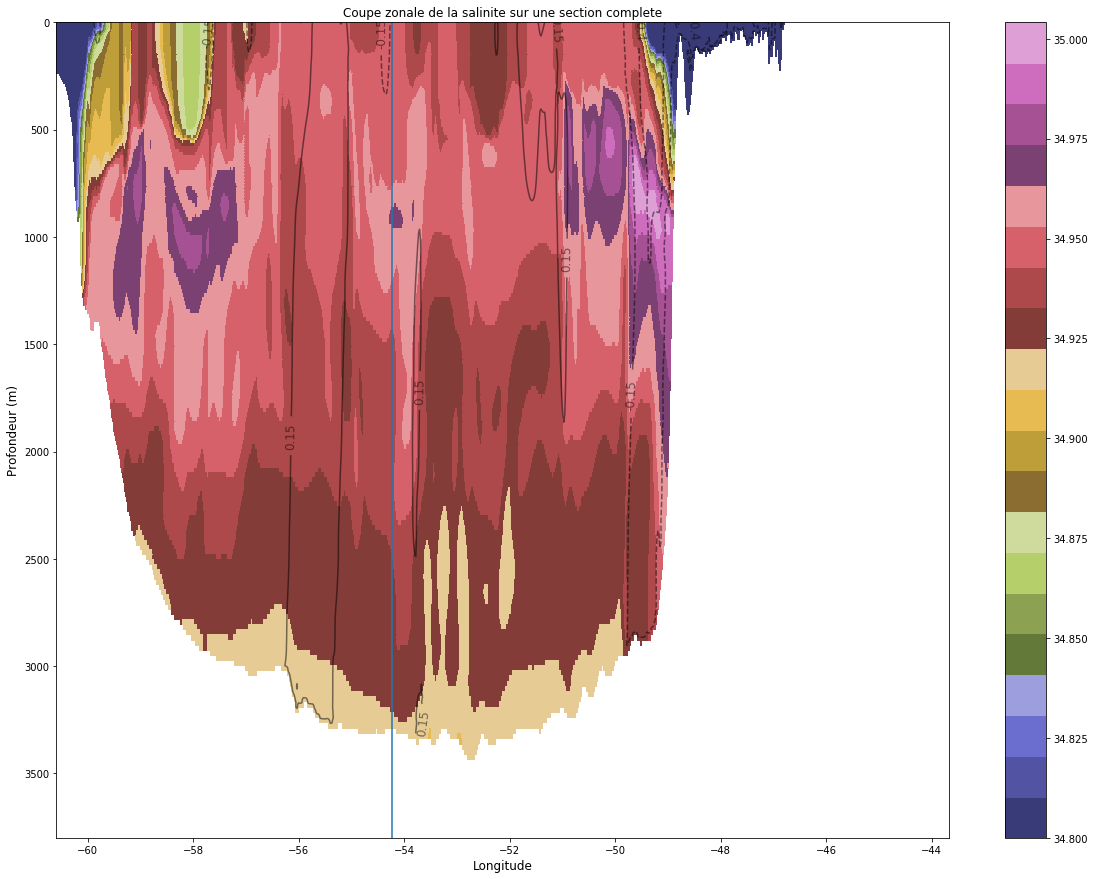

In [128]:
TraceSalinite(lon, DPT, Sx,VITUX, centreX, 0, date, 'SaliniteX')


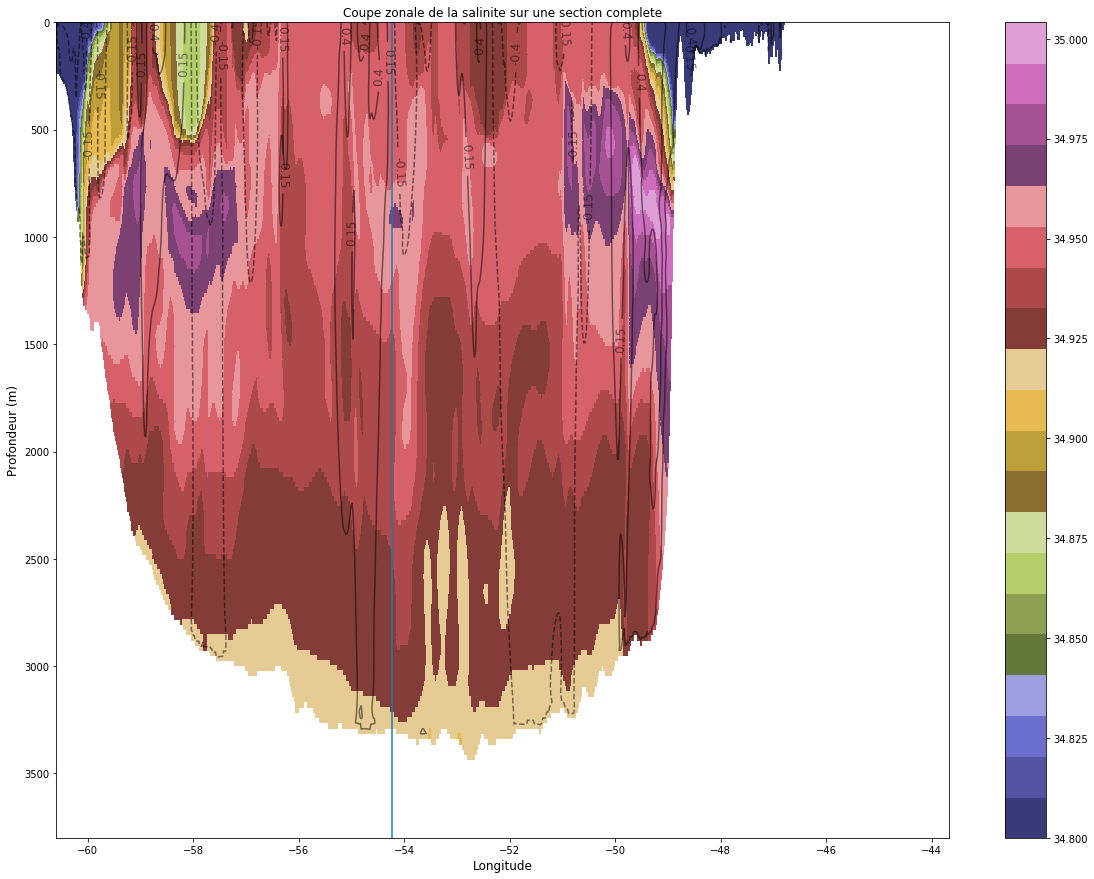

In [129]:
TraceSalinite(lon, DPT, Sx,VITVX, centreX, 0, date, 'SaliniteX')


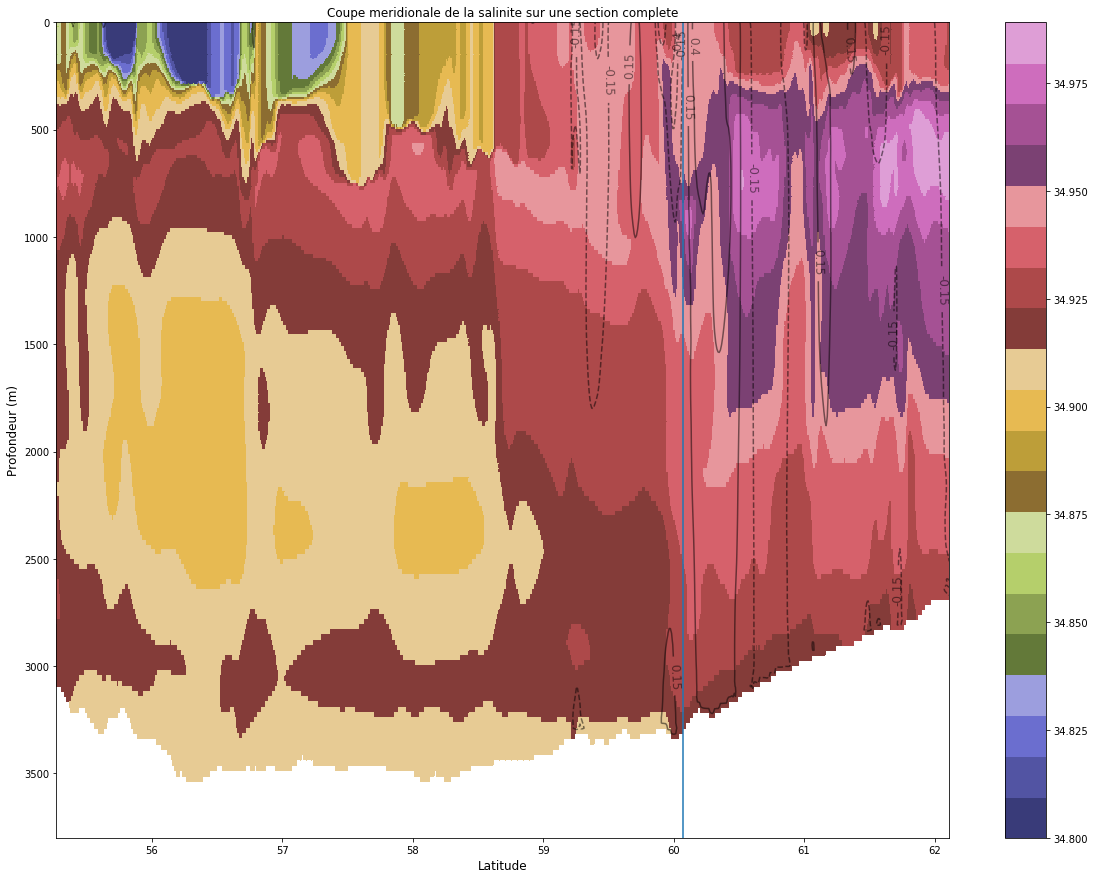

In [130]:
TraceSalinite(lat, DPT, Sy, VITUY, centreY, 0, date, 'SaliniteY')


In [151]:
print(centreX,centreY)

(364, 514)


In [155]:
nav_lat[570,359]

/home/barboty/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  """Entry point for launching an IPython kernel.


masked_array(data=60.56162643432617,
             mask=False,
       fill_value=9.96921e+36,
            dtype=float32)

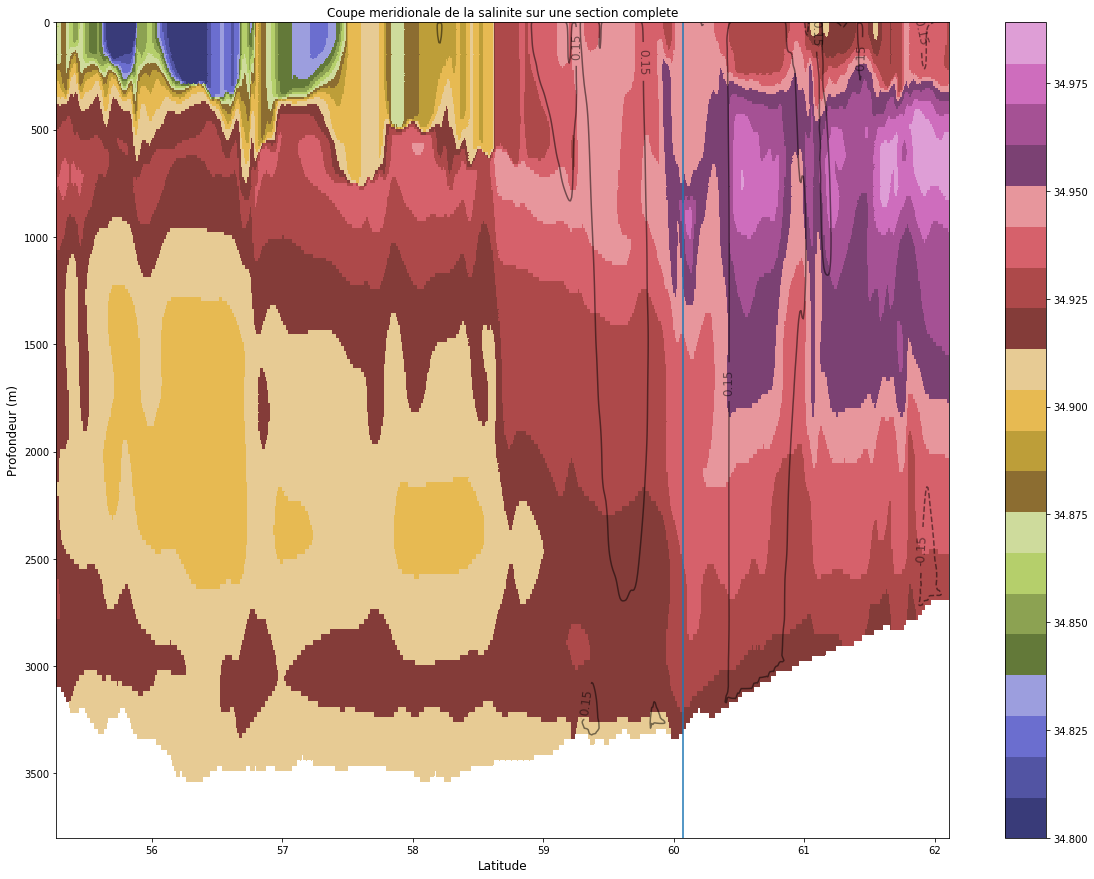

In [131]:
TraceSalinite(lat, DPT, Sy, VITVY, centreY, 0, date, 'SaliniteY')


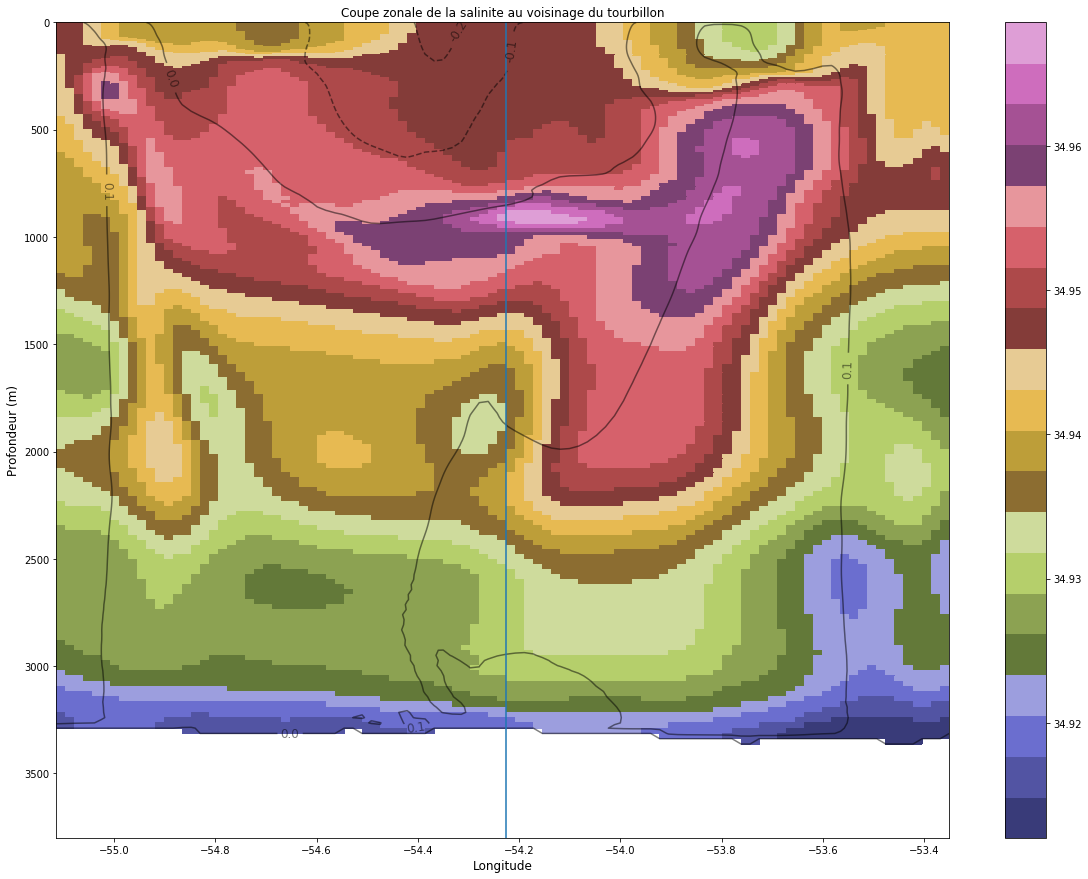

In [132]:



TraceSalinite(INTX, DPT, Sx, VITUX, centreX, 50, date, 'SaliniteX')


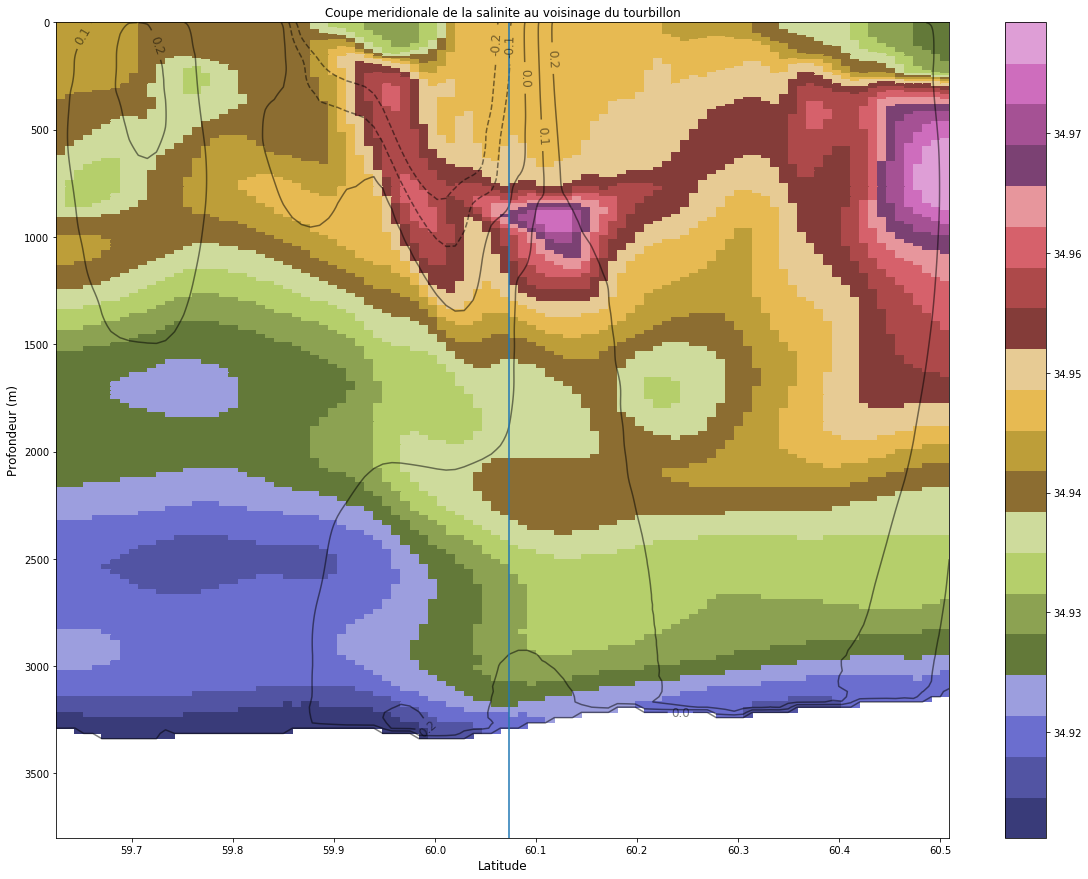

In [133]:
TraceSalinite(INTY, DPT, Sy, VITUY, centreY, 50, date, 'SaliniteY')

In [134]:
lat[centreY]

60.07371

In [135]:
INTY[50]

60.07371

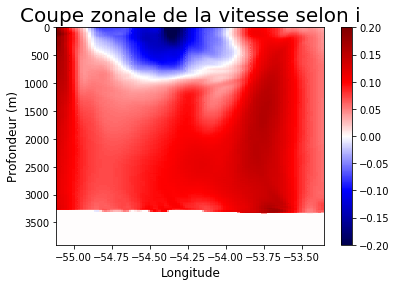

In [72]:
# Trace des vitesses

#ValeurMask = Mas.variables['tmask'][0, :, centreY, :]

#NVIT = ma.masked_where(ValeurMask == 0, VITUX)

Qvit = 'VITUX'

TraceVitesse(INTX, Depth, VITUX, centreX, 50, date, Qvit)


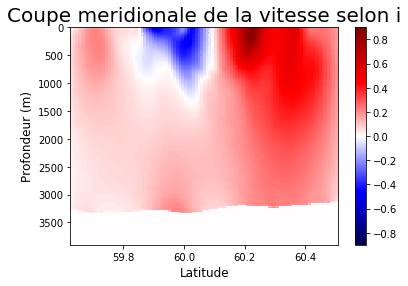

In [73]:
Qvit = 'VITUY'

TraceVitesse(INTY, DPT, VITUY, centreY, 50, date, Qvit)


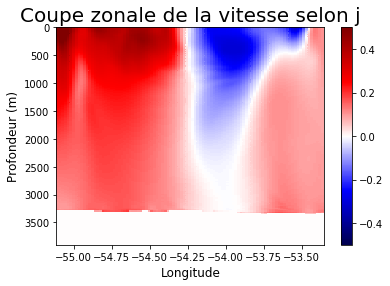

In [74]:
Qvit = 'VITVX'

TraceVitesse(INTX, DPT, VITVX, centreX, 50, date, Qvit)

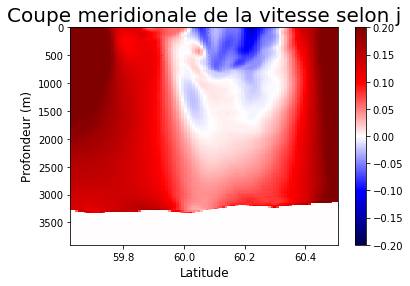

In [75]:
Qvit = 'VITVY'

TraceVitesse(INTY, DPT, VITVY, centreY, 50, date, Qvit)

In [57]:
def TraceTemperature(X,D,T,PosCentre,intervalle, DATE, indice):
    
    ### Permet de tracer la temperature sur un intervalle X, sur tous les niveaux de profondeurs ###
    
    ### Inidice = TempX or TempY ###
    
    Temp = np.array(T)
    Profondeur = 3800
    plt.gca().invert_yaxis()
    ax = plt.subplot(111)
    ax.set_ylim(Profondeur,0)
    ax.set_ylabel('Profondeur (m)',fontsize=12)

    
    if (intervalle == 0):
        if indice[4]=='X':
            plt.title('Coupe zonale de la temperature sur une section complete')
            ax.set_xlabel('Longitude',fontsize=12)

        else:
            plt.title('Coupe meridionale de la temperature sur une section complete')
            ax.set_xlabel('Latitude',fontsize=12)

        pcolor(X,D,T, cmap='jet', vmin = 2, vmax = 6)
        
        contour = ax.contour(X,D,T,[3], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'r', fontsize = 12)

        contour = ax.contour(X,D,T,[4], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'r', fontsize = 12)
        contour = ax.contour(X,D,T,[5], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'r', fontsize = 12)
        
        xx = np.array([X[PosCentre], X[PosCentre]])
        yy = np.array([Profondeur, 0])
        plt.plot(xx, yy)


    else :
        if indice[4]=='X':
            plt.title('Coupe zonale de la temperature au voisinage du tourbillon')
            ax.set_xlabel('Longitude',fontsize=12)
        else:
            plt.title('Coupe meridionale de la temperature au voisinage du tourbillon')
            ax.set_xlabel('Latitude',fontsize=12)

    if (PosCentre-intervalle<0 and intervalle != 0):
        pcolor(X, D, T[:,0:PosCentre+intervalle],cmap='jet', vmin = 2, vmax = 6)
        contour = ax.contour(X,D,T,[3], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'r', fontsize = 12)

        contour = ax.contour(X,D,T,[4], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'r', fontsize = 12)
        contour = ax.contour(X,D,T,[5], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'r', fontsize = 12)
        
        xx = np.array([X[len(X)-50], X[len(X)-50]])
        yy = np.array([Profondeur, 0])
        plt.plot(xx, yy)

    elif (PosCentre-intervalle>=0 and intervalle != 0):
        pcolor(X, D, T[:,PosCentre-intervalle:PosCentre+intervalle],cmap='jet', vmin = 2, vmax = 6)
        contour = ax.contour(X,D,T,[3], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'r', fontsize = 12)

        contour = ax.contour(X,D,T,[4], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'r', fontsize = 12)
        contour = ax.contour(X,D,T,[5], colors = 'black', alpha = 0.5, linewidth = 1, antialiased = True)
        plt.clabel(contour,fmt =  '%r',colors = 'r', fontsize = 12)
        
        xx = np.array([X[50], X[50]])
        yy = np.array([Profondeur, 0])
        plt.plot(xx, yy)


    plt.colorbar()

    plt.savefig(DATE + indice,bbox_inches='tight')

/home/barboty/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/barboty/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


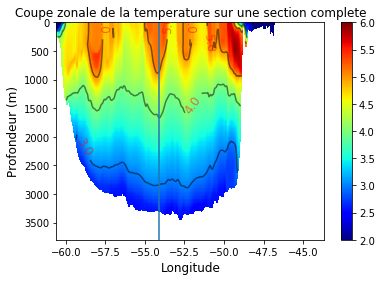

In [33]:
TraceTemperature(lon, DPT, Tx,centreX, 0, date, 'TempX')


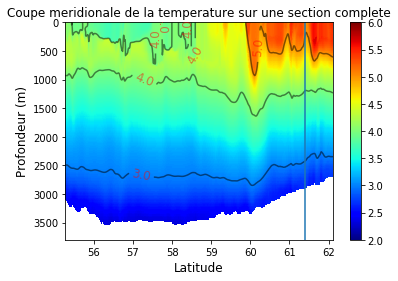

In [34]:
TraceTemperature(lat, DPT, Ty,centreY, 0, date, 'TempY')


In [52]:
# Creation des tableaux de couche de melange

MXL_Y = MXL[:,centreX]
MXL_X = MXL[centreY,:]

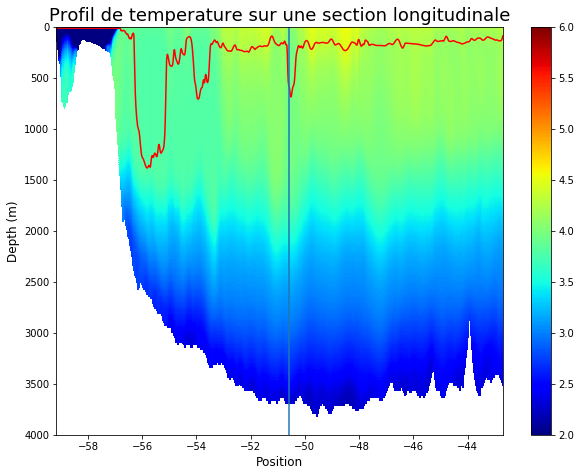

In [233]:
# Trace du profil de temperature sur une coupe zonale

plt.figure(figsize=(10,7.5))
plt.gca().invert_yaxis()
ax = plt.subplot(111)
ax.set_ylim(4000,0)
#ax.set_xlim(-60.7,-46.5)
ax.set_ylabel('Profondeur (m)',fontsize=12)
ax.set_xlabel('Longitude',fontsize=12)
plt.title('Coupe zonale de la température', fontsize = 18)

pcolor(lon, Depth, Tx,cmap='jet', vmin=2, vmax=6)
plt.colorbar()
plt.plot(lon, MXL_X, 'r')


# Plot position tourbillon

xx = np.array([lon[centreX], lon[centreX]])
yy = np.array([4000, 0])
plt.plot(xx, yy)


plt.savefig(str(jour)+'_'+ mois +'_'+ annee+'_Temperature_x',bbox_inches='tight')

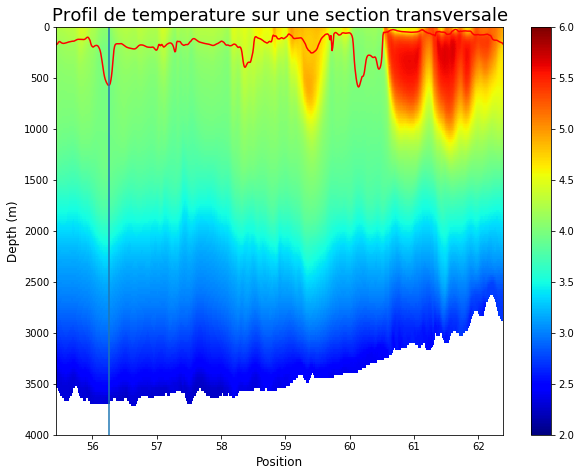

In [234]:
# Trace du profil de temperature sur une coupe transversale

plt.figure(figsize=(10,7.5))
plt.gca().invert_yaxis()
ax = plt.subplot(111)
ax.set_ylim(4000,0)
ax.set_ylabel('Profondeur (m)',fontsize=12)
ax.set_xlabel('Latitude',fontsize=12)
plt.title('Coupe meridionale de la temperature', fontsize = 18)

pcolor(lat, Depth, Ty,cmap='jet', vmin=2, vmax=6)
plt.colorbar()
plt.plot(lat, MXL_Y, 'r')


# Plot position tourbillon

xx = np.array([lat[centreY], lat[centreY]])
yy = np.array([4000, 0])
plt.plot(xx, yy)


plt.savefig(str(jour)+'_'+ mois +'_'+ annee+'_Temperature_y',bbox_inches='tight')

(942,)

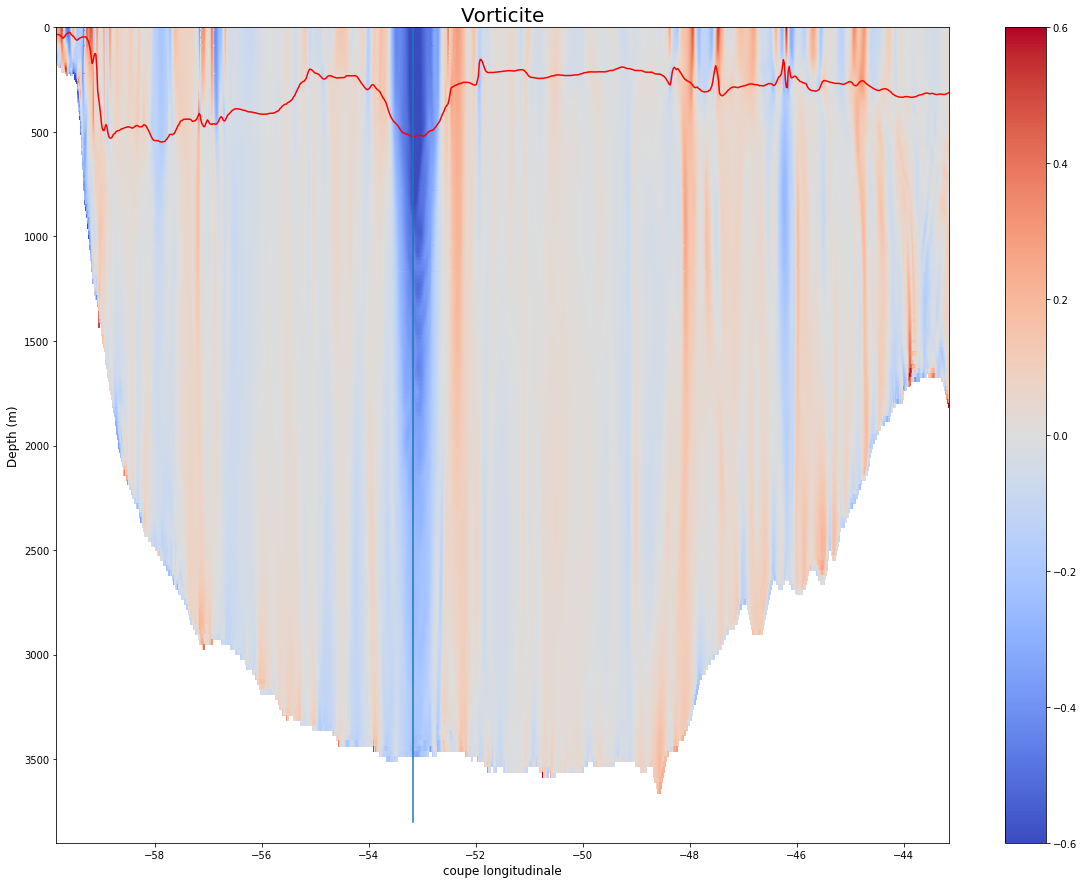

In [53]:
# Trace coupe longitudinale de la vorticite a une date donnee sur tous les niveaux
# Passant par le centre du tourbillon etudie


plt.figure(figsize=(20,15))
plt.gca().invert_yaxis()
ax = plt.subplot(111)
ax.set_ylim(3900,0)
#ax.set_xlim(-60.7,-46)
ax.set_ylabel('Profondeur (m)',fontsize=12)
ax.set_xlabel('longitude',fontsize=12)

plt.title('coupe zonale de la vorticite', fontsize = 20)
pcolor(lon, DPT, VV,cmap='coolwarm',vmin = -0.6,vmax = 0.6)
plt.colorbar()
plt.plot(lon, MXL_X, 'r')

xx = np.array([lon[centreX], lon[centreX]])
yy = np.array([3800, 0])
plt.plot(xx, yy)

plt.savefig(str(jour)+'_'+ mois +'_'+ annee+'_Vorticite_x',bbox_inches='tight')
show()

1206.37

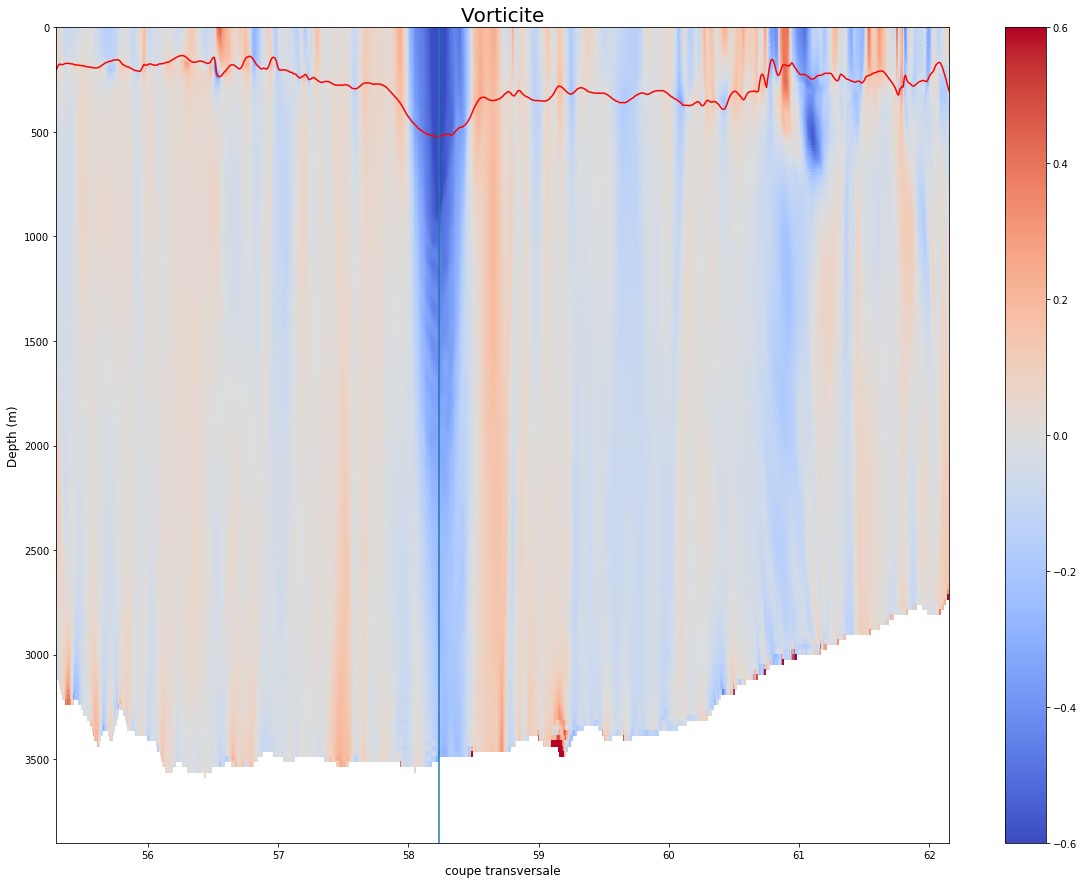

In [54]:
# Trace coupe transversale de la vorticite a une date donnee sur tous les niveaux
# Passant par le centre du tourbillon etudie



plt.figure(figsize=(20,15))
plt.gca().invert_yaxis()
ax = plt.subplot(111)
ax.set_ylim(3900,0)
ax.set_ylabel('Profondeur (m)',fontsize=12)
ax.set_xlabel('Latitude',fontsize=12)


plt.title('Coupe meridionale de la vorticite', fontsize = 20)

pcolor(lat, DPT, UU,cmap='coolwarm',vmin = -0.6,vmax = 0.6)
plt.colorbar()
plt.plot(lat, MXL_Y, 'r')

xx = np.array([lat[centreY], lat[centreY]])
yy = np.array([4000, 0])
plt.plot(xx, yy)

plt.savefig(str(jour)+'_'+ mois +'_'+ annee+'_Vorticite_y',bbox_inches='tight')


show()

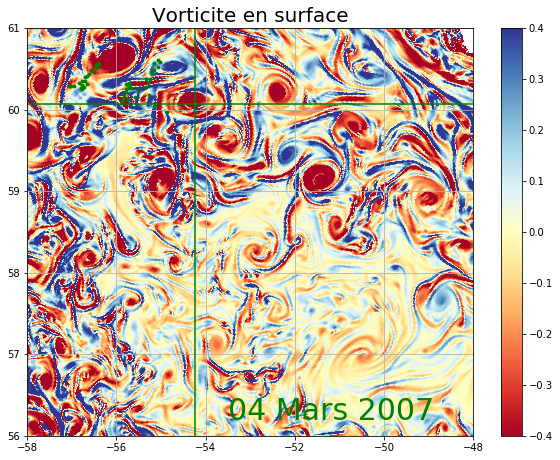

In [135]:
# Affichage de la carte de vorticite en surface, projetee et trace de la vie du tourbillon suivi

plt.figure(figsize=(10,7.5))

ax = plt.subplot(111)
plt.title('Vorticite en surface', fontsize = 20)
plt.pcolormesh(nav_lon,nav_lat,vv, cmap='seismic',vmin = -0.4, vmax=0.4)
plt.colorbar()
plt.xlim(-58,-48)
plt.ylim(56,61)
plt.grid(axis='both')
for i in range (20):  
    plt.scatter(A[i][0],A[i][1],linewidth='0', s=15, color='g') #Janv
for i in range (len(B)):
    plt.scatter(B[i][0],B[i][1],linewidth='0', s=15, color='g') #Fevr
for i in range (4):    
    plt.scatter(C[i][0],C[i][1],linewidth='0', s=15, color='g') #Mars
#for i in range (len(D)):
#    plt.scatter(D[i][0],D[i][1],linewidth='0', s=15, color='w') #Avril
#for i in range (len(E)):   
#    plt.scatter(E[i][0],E[i][1],linewidth='0', s=15, color='w') #Mai
#for i in range (len(F)):
#    plt.scatter(F[i][0],F[i][1],linewidth='0', s=15, color='w') #Juin
#for i in range (len(G)):
#    plt.scatter(G[i][0],G[i][1],linewidth='0', s=15, color='w') #Juill
#for i in range (len(H)):
#    plt.scatter(H[i][0],H[i][1],linewidth='0', s=15, color='w') #Aout
#for i in range (len(I)):
#    plt.scatter(I[i][0],I[i][1],linewidth='0', s=15, color='w') #Sept
#for i in range (len(J)):
#    plt.scatter(J[i][0],J[i][1],linewidth='0', s=15, color='w') #Oct
#for i in range (len(K)):
#    plt.scatter(K[i][0],K[i][1],linewidth='0', s=15, color='w') #Nov
#for i in range (len(L)):
#    plt.scatter(L[i][0],L[i][1],linewidth='0', s=15, color='w') #Dec
#for i in range (len(M)):  
#    plt.scatter(M[i][0],M[i][1],linewidth='0', s=15, color='w') #Janv
#for i in range (len(N)):
#    plt.scatter(N[i][0],N[i][1],linewidth='0', s=15, color='w') #Fev
#for i in range (len(O)):    
#    plt.scatter(O[i][0],O[i][1],linewidth='0', s=15, color='w') #Mars
#for i in range (len(P)):
#    plt.scatter(P[i][0],P[i][1],linewidth='0', s=15, color='w') #Avril
#for i in range (len(Q)):   
#    plt.scatter(Q[i][0],Q[i][1],linewidth='0', s=15, color='w') #Mai
#for i in range (len(R)):
#    plt.scatter(R[i][0],R[i][1],linewidth='0', s=15, color='w') #Juin
#for i in range (len(S)):
#    plt.scatter(S[i][0],S[i][1],linewidth='0', s=15, color='w') #Juillet
#for i in range (len(T)):
#    plt.scatter(T[i][0],T[i][1],linewidth='0', s=15, color='w') #Aout
#for i in range (len(U)):
#    plt.scatter(U[i][0],U[i][1],linewidth='0', s=15, color='w') #Sept
#for i in range (len(V)):
#    plt.scatter(V[i][0],V[i][1],linewidth='0', s=15, color='w') #Oct
#for i in range (len(W)):
#    plt.scatter(W[i][0],W[i][1],linewidth='0', s=15, color='w') #Nov
#for i in range (len(X)):
#    plt.scatter(X[i][0],X[i][1],linewidth='0', s=15, color='w') #Dec

xx = np.array([lat[centreY], lat[centreY]])
yy = np.array([-58, -48])
plt.plot(yy, xx, 'g')

XX = np.array([lon[centreX], lon[centreX]])
YY = np.array([56, 61])
plt.plot(XX, YY, 'g')


plt.text(-53.5,56.2,j +' '+ Mois +' '+ annee, color = 'green', size = 30)
plt.savefig('Vorticite_en_surface_et_suivi',bbox_inches='tight')


In [ ]:
# Pour créer un film artificiel de la vorticite a tous les niveaux

### ATTENTION : le script est très long à s'achever lorsqu'il est execute ! A manier avec precaution ###
jsogdjôgjĵ
for i in range(300):
    VV = f.variables['socurloverf'][0,i,:,:]

    plt.figure(figsize=(10,7.5))
    ax = plt.subplot(111)
    #plt.xlim(-58,-48)
    #plt.ylim(56,61)
    if (i==0):
        plt.title('Vorticite en surface', fontsize = 20)
        plt.pcolormesh(nav_lon,nav_lat,VV, vmin = -0.3, vmax=0.3)
        plt.colorbar()
        plt.grid(axis='both')
        plt.savefig('Vorticite en surface', bbox_inches = 'tight')
    else:
        plt.title('Vorticite au '+str(i+1)+' niveau', fontsize = 20)
        plt.pcolormesh(nav_lon,nav_lat,VV, vmin = -0.3, vmax=0.3)
        plt.colorbar()
        plt.grid(axis='both')
        plt.savefig(str(i+1)+'eme_Niveau',bbox_inches='tight')

In [ ]:
##############################################

##### Pour avoir une idée plus grossiere #####

##############################################

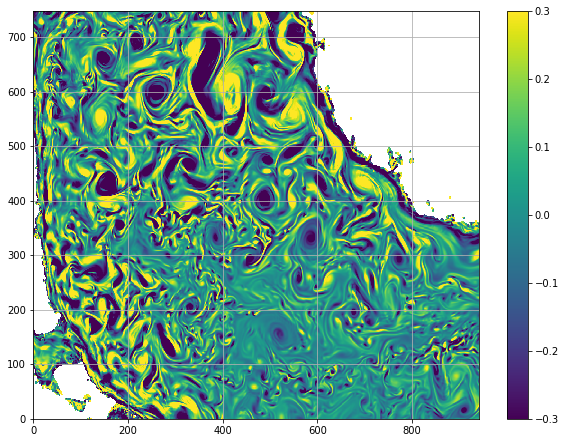

In [215]:
f = Dataset(CompletePath, "r", format = "NETCDF4")
VV = f.variables['socurloverf'][0,49,:,:]

plt.figure(figsize=(10,7.5))
plt.pcolormesh(ma.masked_invalid(np.squeeze(VV)), vmin = -0.3, vmax=0.3)
plt.colorbar()
plt.grid(axis='both')
plt.savefig('Vorticite_250m',bbox_inches='tight')

<function matplotlib.pyplot.show>

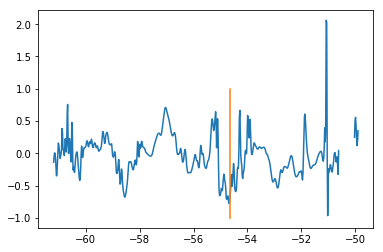

In [66]:
TestV = f.variables['socurloverf'][0,35,centreY,:]

plt.plot(lon,TestV)


xx = np.array([lon[centreX], lon[centreX]])
yy = np.array([-1, 1])
plt.plot(xx, yy)

plt.show

<function matplotlib.pyplot.show>

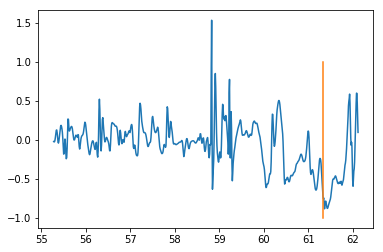

In [67]:
TestV = f.variables['socurloverf'][0,35,:,centreX]

plt.plot(lat,TestV)

xx = np.array([lat[centreY], lat[centreY]])
yy = np.array([-1, 1])
plt.plot(xx, yy)


plt.show

<function matplotlib.pyplot.show>

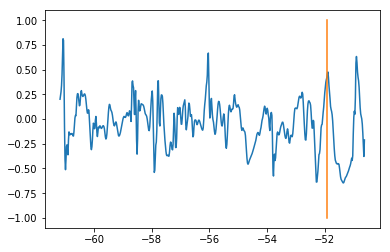

In [216]:
TestV = f.variables['socurloverf'][0,62,703,:]

plt.plot(lon,TestV)


xx = np.array([lon[523], lon[523]])
yy = np.array([-1, 1])
plt.plot(xx, yy)

plt.show

<function matplotlib.pyplot.show>

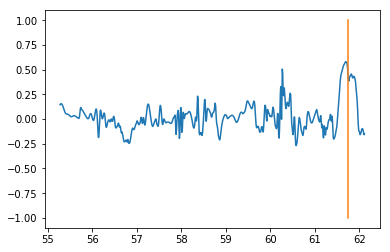

In [217]:
TestV = f.variables['socurloverf'][0,62,:,523]

plt.plot(lat,TestV)

xx = np.array([lat[703], lat[703]])
yy = np.array([-1, 1])
plt.plot(xx, yy)


plt.show

<function matplotlib.pyplot.show>

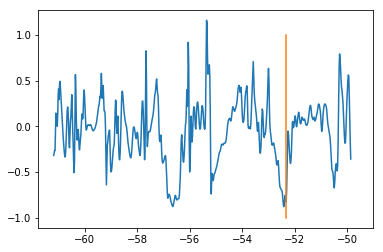

In [72]:
TestV = f.variables['socurloverf'][0,35,centreY,:]

plt.plot(lon,TestV)


xx = np.array([lon[centreX], lon[centreX]])
yy = np.array([-1, 1])
plt.plot(xx, yy)

plt.show

<function matplotlib.pyplot.show>

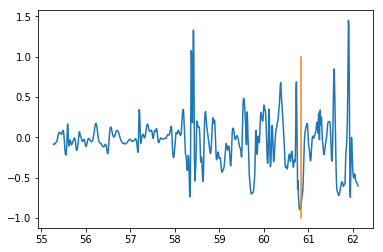

In [73]:
TestV = f.variables['socurloverf'][0,35,:,centreX]

plt.plot(lat,TestV)

xx = np.array([lat[centreY], lat[centreY]])
yy = np.array([-1, 1])
plt.plot(xx, yy)


plt.show

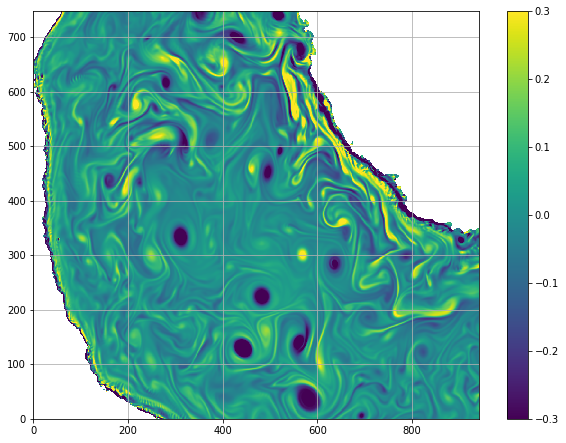

In [202]:
f = Dataset(CompletePath, "r", format = "NETCDF4")
VV = f.variables['socurloverf'][0,105,:,:]

plt.figure(figsize=(10,7.5))
plt.pcolormesh(ma.masked_invalid(np.squeeze(VV)), vmin = -0.3, vmax=0.3)
plt.colorbar()
plt.grid(axis='both')
plt.savefig('Vorticite_1000m',bbox_inches='tight')

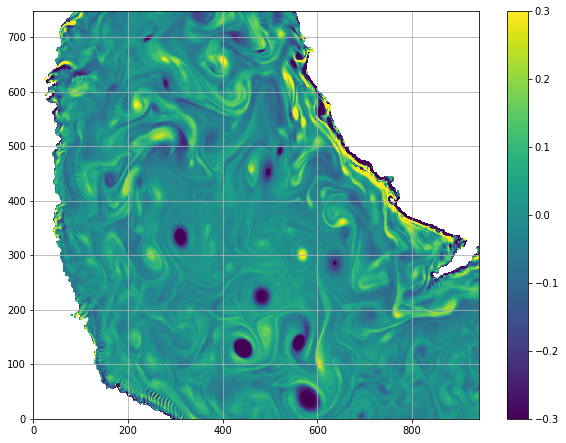

In [203]:
#Test entre les niveaux 105 et 156 (1000 et 2000m)


f = Dataset(CompletePath, "r", format = "NETCDF4")
VV = f.variables['socurloverf'][0,145,:,:]

plt.figure(figsize=(10,7.5))
plt.pcolormesh(ma.masked_invalid(np.squeeze(VV)), vmin = -0.3, vmax=0.3)
plt.colorbar()
plt.grid(axis='both')
plt.savefig('Vorticite_1750m',bbox_inches='tight')

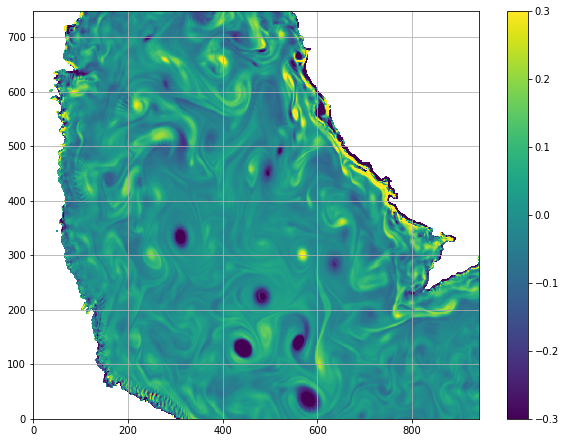

In [204]:
f = Dataset(CompletePath, "r", format = "NETCDF4")
VV = f.variables['socurloverf'][0,156,:,:]

plt.figure(figsize=(10,7.5))
plt.pcolormesh(ma.masked_invalid(np.squeeze(VV)), vmin = -0.3, vmax=0.3)
plt.colorbar()
plt.grid(axis='both')
plt.savefig('Vorticite_2000m',bbox_inches='tight')

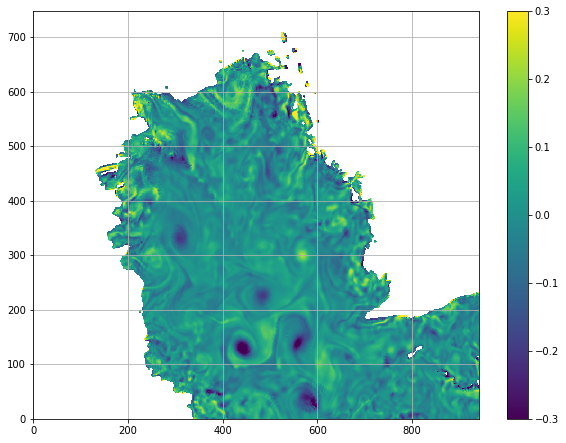

In [205]:
f = Dataset(CompletePath, "r", format = "NETCDF4")
VV = f.variables['socurloverf'][0,200,:,:]

plt.figure(figsize=(10,7.5))
plt.pcolormesh(ma.masked_invalid(np.squeeze(VV)), vmin = -0.3, vmax=0.3)
plt.colorbar()
plt.grid(axis='both')
plt.savefig('Vorticite_3000m',bbox_inches='tight')